<a href="https://colab.research.google.com/github/haresh93/ERA-submissions/blob/main/S10/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/haresh93/ERA-submissions.git
%cd ERA-submissions/S10/

Cloning into 'ERA-submissions'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 118 (delta 48), reused 59 (delta 20), pack-reused 0
Receiving objects: 100% (118/118), 593.81 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/ERA-submissions/S10


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchsummary
!pip3 install tqdm
!pip3 install albumentations
!pip3 install torch_lr_finder

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
cuda = torch.cuda.is_available()
print("Cuda Available: ", cuda)

device = torch.device("cuda" if cuda else "cpu")

Cuda Available:  True


In [5]:
# Train and Test Transforms
train_transforms = A.Compose([
        A.PadIfNeeded(min_height=40, min_width=40, value=(0.4914, 0.4822, 0.4465), p=1), # Padding with a border of 4 pixels
        A.RandomCrop(width=32, height=32),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8,
                       min_holes = 1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
        A.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
])

test_transforms = A.Compose([
                                      A.Normalize( (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                      ToTensorV2(),
])

In [6]:
# Train and Test Datasets
from dataset import Cifar10SearchDataset
train_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=True, download=True,
                    transform=train_transforms)
test_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=False, download=True,
                    transform=test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 14146434.26it/s]


Extracting /root/data/CIFAR10/cifar-10-python.tar.gz to /root/data/CIFAR10
Files already downloaded and verified


In [7]:
dataloader_args = dict(shuffle = True, batch_size = 512, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

In [8]:
from custom_resnet import model_summary, Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.80E-02


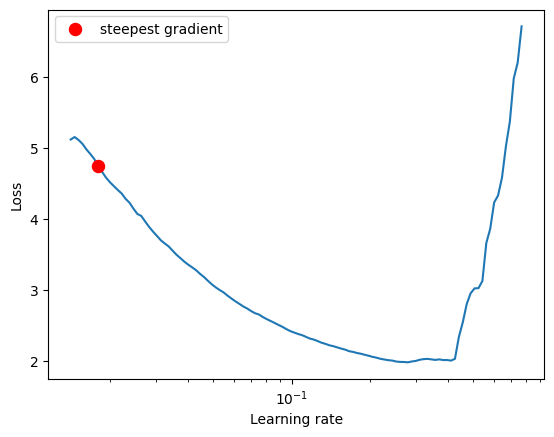

In [9]:
from torch_lr_finder import LRFinder

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device = 'cuda')
lr_finder.range_test(train_dataloader, end_lr = 10, num_iter = 200, step_mode = "exp")
lr_finder.plot()
lr_finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
from train import model_train, model_test

EPOCHS = 24

scheduler = OneCycleLR(
    optimizer,
    max_lr = 0.018,
    steps_per_epoch=len(train_dataloader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor=100,
    three_phase = False,
    final_div_factor=1000,
    anneal_strategy='linear'
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_train(model, device, train_dataloader, optimizer, scheduler, criterion, epoch)
    model_test(model, device, test_dataloader, criterion)

EPOCH: 0


Train: Loss=1.1662 Batch_id=97 Accuracy=50.38: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]



Test set: Average loss: 0.0024, Accuracy: 5881/10000 (58.81%)

EPOCH: 1


Train: Loss=0.6967 Batch_id=97 Accuracy=69.39: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]



Test set: Average loss: 0.0028, Accuracy: 6058/10000 (60.58%)

EPOCH: 2


Train: Loss=0.8271 Batch_id=97 Accuracy=74.71: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]



Test set: Average loss: 0.0016, Accuracy: 7349/10000 (73.49%)

EPOCH: 3


Train: Loss=0.7506 Batch_id=97 Accuracy=77.02: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]



Test set: Average loss: 0.0020, Accuracy: 6977/10000 (69.77%)

EPOCH: 4


Train: Loss=0.6119 Batch_id=97 Accuracy=78.82: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0012, Accuracy: 7898/10000 (78.98%)

EPOCH: 5


Train: Loss=0.6001 Batch_id=97 Accuracy=81.53: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]



Test set: Average loss: 0.0014, Accuracy: 7702/10000 (77.02%)

EPOCH: 6


Train: Loss=0.4431 Batch_id=97 Accuracy=83.15: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]



Test set: Average loss: 0.0013, Accuracy: 7888/10000 (78.88%)

EPOCH: 7


Train: Loss=0.4242 Batch_id=97 Accuracy=84.14: 100%|██████████| 98/98 [00:08<00:00, 10.97it/s]



Test set: Average loss: 0.0010, Accuracy: 8320/10000 (83.20%)

EPOCH: 8


Train: Loss=0.4450 Batch_id=97 Accuracy=84.91: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0014, Accuracy: 7779/10000 (77.79%)

EPOCH: 9


Train: Loss=0.4734 Batch_id=97 Accuracy=85.52: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0013, Accuracy: 7798/10000 (77.98%)

EPOCH: 10


Train: Loss=0.5712 Batch_id=97 Accuracy=86.23: 100%|██████████| 98/98 [00:08<00:00, 11.05it/s]



Test set: Average loss: 0.0011, Accuracy: 8263/10000 (82.63%)

EPOCH: 11


Train: Loss=0.3306 Batch_id=97 Accuracy=87.01: 100%|██████████| 98/98 [00:08<00:00, 11.11it/s]



Test set: Average loss: 0.0011, Accuracy: 8250/10000 (82.50%)

EPOCH: 12


Train: Loss=0.3548 Batch_id=97 Accuracy=87.16: 100%|██████████| 98/98 [00:08<00:00, 11.11it/s]



Test set: Average loss: 0.0009, Accuracy: 8380/10000 (83.80%)

EPOCH: 13


Train: Loss=0.3628 Batch_id=97 Accuracy=87.68: 100%|██████████| 98/98 [00:08<00:00, 10.95it/s]



Test set: Average loss: 0.0010, Accuracy: 8375/10000 (83.75%)

EPOCH: 14


Train: Loss=0.3299 Batch_id=97 Accuracy=88.18: 100%|██████████| 98/98 [00:09<00:00, 10.71it/s]



Test set: Average loss: 0.0008, Accuracy: 8653/10000 (86.53%)

EPOCH: 15


Train: Loss=0.3130 Batch_id=97 Accuracy=88.93: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]



Test set: Average loss: 0.0009, Accuracy: 8433/10000 (84.33%)

EPOCH: 16


Train: Loss=0.2936 Batch_id=97 Accuracy=89.71: 100%|██████████| 98/98 [00:08<00:00, 10.97it/s]



Test set: Average loss: 0.0008, Accuracy: 8725/10000 (87.25%)

EPOCH: 17


Train: Loss=0.3486 Batch_id=97 Accuracy=90.46: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]



Test set: Average loss: 0.0008, Accuracy: 8682/10000 (86.82%)

EPOCH: 18


Train: Loss=0.2579 Batch_id=97 Accuracy=91.16: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]



Test set: Average loss: 0.0007, Accuracy: 8823/10000 (88.23%)

EPOCH: 19


Train: Loss=0.2287 Batch_id=97 Accuracy=92.11: 100%|██████████| 98/98 [00:08<00:00, 11.11it/s]



Test set: Average loss: 0.0006, Accuracy: 8996/10000 (89.96%)

EPOCH: 20


Train: Loss=0.2186 Batch_id=97 Accuracy=93.10: 100%|██████████| 98/98 [00:08<00:00, 11.00it/s]



Test set: Average loss: 0.0006, Accuracy: 9001/10000 (90.01%)

EPOCH: 21


Train: Loss=0.1940 Batch_id=97 Accuracy=94.46: 100%|██████████| 98/98 [00:08<00:00, 11.10it/s]



Test set: Average loss: 0.0005, Accuracy: 9163/10000 (91.63%)

EPOCH: 22


Train: Loss=0.1385 Batch_id=97 Accuracy=95.57: 100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Test set: Average loss: 0.0005, Accuracy: 9244/10000 (92.44%)

EPOCH: 23


Train: Loss=0.1016 Batch_id=97 Accuracy=96.71: 100%|██████████| 98/98 [00:08<00:00, 11.04it/s]



Test set: Average loss: 0.0004, Accuracy: 9330/10000 (93.30%)



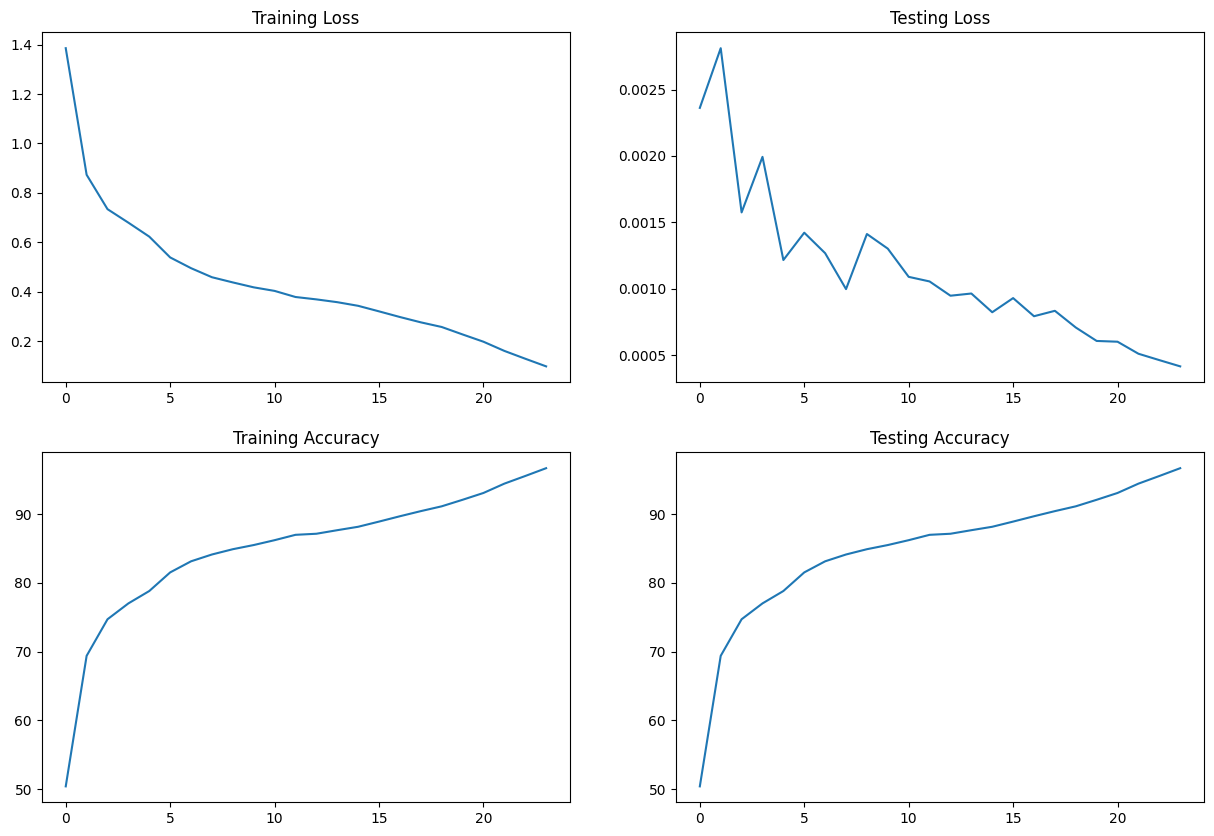

In [11]:
from train import draw_graphs

draw_graphs()